# pybacktest tutorial

This tutorial will give you a quick overview of **pybacktest**'s features. To do so, we will backtest classic MA crossover trading strategy:

* go long when short MA crosses above long MA
* go short when short MA crosses below long MA
* entry rules are also exit rules, thus making strategy reversible

Package is available for download at https://github.com/ematvey/pybacktest

In [1]:
from __future__ import print_function

import pybacktest  # obviously, you should install pybacktest before importing it
import pandas as pd

import tushare as ts
print (ts.__version__) # 因为导入了py3的print功能，print需要用py3的

1.2.15


**pybacktest** expects bars to be in `pandas.DataFrame` indexed by datetimestamps, with columns named `O`, `H`, `L`, `C`. Actually, in this version it would only check `O`, and only if trade prices are not explicitly specified.

Lets load data from yahoo using helper.

In [2]:
# ohlc = pybacktest.load_from_yahoo('SPY')
hs300 = ts.get_hist_data('hs300') # 这个函数只能获取最近三年的数据
hs300.info() 
hs300.index = pd.DatetimeIndex(hs300.index) # 需要把index改为datetimeindex格式，参考https://www.jianshu.com/p/4ece5843d383
hs300 = hs300.sort_index(ascending = True) # 原始数据是按时间降序排列的,改为升序
ohlc = hs300[['open','high','low','close','volume']]
ohlc.columns = ohlc.columns.map(lambda x:x[0].upper())
ohlc.to_csv('D:\\GitHubRepository\\pybacktest\\examples\\ohlc.csv')
ohlc.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 609 entries, 2019-05-30 to 2016-11-29
Data columns (total 13 columns):
open            609 non-null float64
high            609 non-null float64
close           609 non-null float64
low             609 non-null float64
volume          609 non-null float64
price_change    609 non-null float64
p_change        609 non-null float64
ma5             609 non-null float64
ma10            609 non-null float64
ma20            609 non-null float64
v_ma5           609 non-null float64
v_ma10          609 non-null float64
v_ma20          609 non-null float64
dtypes: float64(13)
memory usage: 64.2+ KB


,O,H,L,C,V
date,,,,,
2019-05-24,3584.90,3623.39,3580.79,3593.91,809340.50
2019-05-27,3592.60,3648.03,3556.26,3637.20,1088308.75
2019-05-28,3633.02,3683.23,3627.79,3672.26,1178862.38
2019-05-29,3642.54,3693.23,3637.35,3663.91,933554.44
2019-05-30,3648.85,3650.97,3612.62,3641.18,942025.62


Now time to define strategy. To do so, all we need to do is to create binary `Series` with signals, and, optionally, trade price `Series` with float elements.

Could this be any simpler?

In [17]:
short_ma = 12
long_ma = 30

ms = ohlc.C.rolling(short_ma).mean()
ml = ohlc.C.rolling(long_ma).mean()
    
buy = cover = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
sell = short = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down

buy.to_csv('D:\\GitHubRepository\\pybacktest\\examples\\buy.csv')
sell.to_csv('D:\\GitHubRepository\\pybacktest\\examples\\sell.csv')

print('>  Short MA.shift()\n%s\n' %ms.shift().tail())  # DataFrame.shift()列数据向下移动一位，但index未动
print('>  Short MA\n%s\n' % ms.tail())  # \n 换行符
print('>  Long MA\n%s\n' % ml.tail())
print('>  Buy/Cover signals\n%s\n' % buy.tail())
print('>  Short/Sell signals\n%s\n' % sell.tail())

>  Short MA.shift()
date
2019-05-24    3662.434167
2019-05-27    3656.305000
2019-05-28    3659.430000
2019-05-29    3654.580833
2019-05-30    3654.179167
Name: C, dtype: float64

>  Short MA
date
2019-05-24    3656.305000
2019-05-27    3659.430000
2019-05-28    3654.580833
2019-05-29    3654.179167
2019-05-30    3653.848333
Name: C, dtype: float64

>  Long MA
date
2019-05-24    3836.034667
2019-05-27    3821.079667
2019-05-28    3810.235667
2019-05-29    3799.412000
2019-05-30    3788.267333
Name: C, dtype: float64

>  Buy/Cover signals
date
2019-05-24    False
2019-05-27    False
2019-05-28    False
2019-05-29    False
2019-05-30    False
Name: C, dtype: bool

>  Short/Sell signals
date
2019-05-24    False
2019-05-27    False
2019-05-28    False
2019-05-29    False
2019-05-30    False
Name: C, dtype: bool



Time to run backtest. `Backtest` will try to extract signals and prices and bars from whatever dict-like object you passed as first argument. Could be dict, could be pandas.DataFrame or anything.

To make thing easier, pass local namespace (extracted py calling `locals()`), that contains every variable you created up to this point.

In [18]:
bt = pybacktest.Backtest(locals(), 'ma_cross')
print(bt)

Backtest(ma_cross, 2019-31-05 00:47)


`Backtest` runs lazily, i.e. it calculates anything only when you call properties from it. There properties: 

In [19]:
print(list(filter(lambda x: not x.startswith('_'), dir(bt))))
print('\n>  bt.signals\n%s' % bt.signals.tail())
print('\n>  bt.trades\n%s' % bt.trades.tail())
print('\n>  bt.positions\n%s' % bt.positions.tail())
print('\n>  bt.equity\n%s' % bt.equity.tail())
print('\n>  bt.trade_price\n%s' % bt.trade_price.tail())

['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'stats', 'summary', 'trade_price', 'trades', 'trdplot']

>  bt.signals
              Buy  Cover   Sell  Short
date                                  
2019-05-24  False  False  False  False
2019-05-27  False  False  False  False
2019-05-28  False  False  False  False
2019-05-29  False  False  False  False
2019-05-30  False  False  False  False

>  bt.trades
            pos    price  vol
date                         
2018-12-03 -1.0  3260.69 -2.0
2018-12-04  1.0  3256.23  2.0
2018-12-05 -1.0  3224.26 -2.0
2019-01-22  1.0  3181.95  2.0
2019-05-09 -1.0  3637.35 -2.0

>  bt.positions
date
2018-11-30   -1.0
2018-12-03    1.0
2018-12-04   -1.0
2019-01-21    1.0
2019-05-08   -1.0
dtype: float64

>  bt.equity
date
2018-12-03     59.41
2018-12-04      4.46
2018-12-05    -31.97
2019-01-22     42.31
2019-05-09    455.40
dtype: float64

>  

Some of popular performance statistics could be requested by calling `summary` method of `Backtest`.

In [20]:
bt.summary()

------------------------------------------
|  Backtest(ma_cross, 2019-31-05 00:47)  |
------------------------------------------

backtest:
  days: 742
  from: '2017-04-27 00:00:00'
  to: '2019-05-09 00:00:00'
  trades: 21
performance:
  PF: 0.8509
  RF: -0.2098
  averages:
    gain: 153.3344
    loss: -135.1483
    trade: -11.5129
  payoff: 1.1346
  profit: -241.77
  winrate: 0.4286
risk/return profile:
  MPI: -0.0115
  UPI: -0.0143
  WCDD (monte-carlo 0.99 quantile): 1270.2605
  maxdd: 1152.49
  sharpe: -0.1667
  sortino: -0.0549

------------------------------------------


Now lets look at equity curve.

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114f8870>)

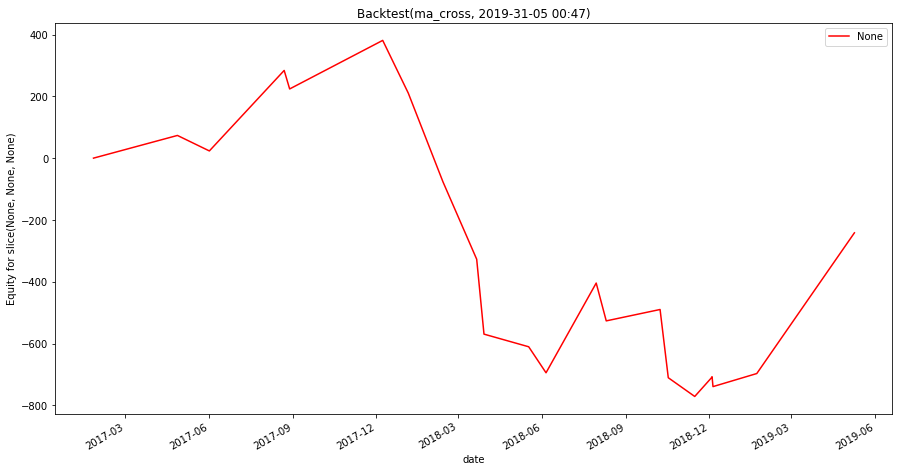

In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

bt.plot_equity()

But what if you want to see what exactly was going on during backtest run? Well, `Backtest` can plot trades as they happened for you. Legend is hidden by default to save space.

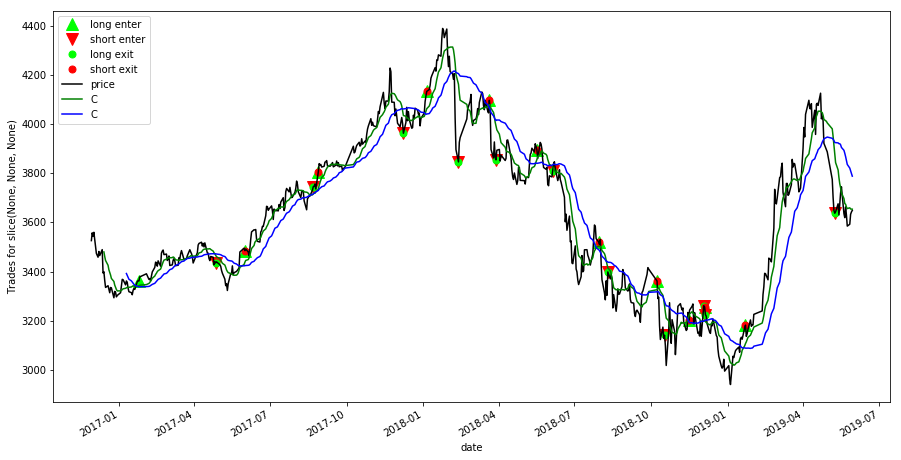

In [22]:
bt.plot_trades()
ohlc.C.rolling(short_ma).mean().plot(c='green')
ohlc.C.rolling(long_ma).mean().plot(c='blue')
plt.legend(loc='upper left')
pass

Can you see anything there? I can't. That's why we have special a very special `trdplot` property, which allowes you specify what period do you want to plot using standard `pandas` indexing mechanisms. Same trick could be done with equity curve using `eqplot` property.

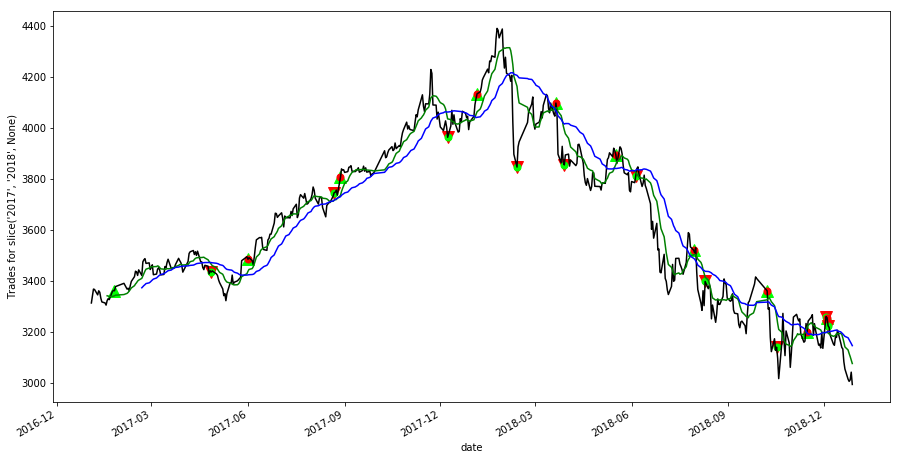

In [23]:
bt.trdplot['2017':'2018']
ohlc.C['2017':'2018'].rolling(short_ma).mean().plot(c='green')
ohlc.C['2017':'2018'].rolling(long_ma).mean().plot(c='blue')
pass

That's the most of it.